In [1]:
import os
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. LOAD AND PREPROCESS DATA

# Define folder path
base_folder = "./IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"


# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube

# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))

# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

R = (reference_cube - dark_cube) / denominator
reference = np.clip(R, 0, 1)

# Load and compute reflectance for each sample
reflectance_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    reflectance_cubes[folder] =  np.clip(R, 0, 1)  # Shape: (bands, height, width)

def normalize(ref): # do we need?
    return (ref - np.min(ref)) / (np.max(ref) - np.min(ref))

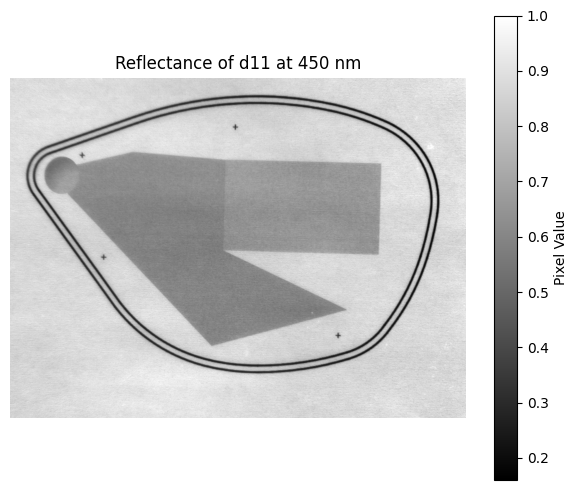

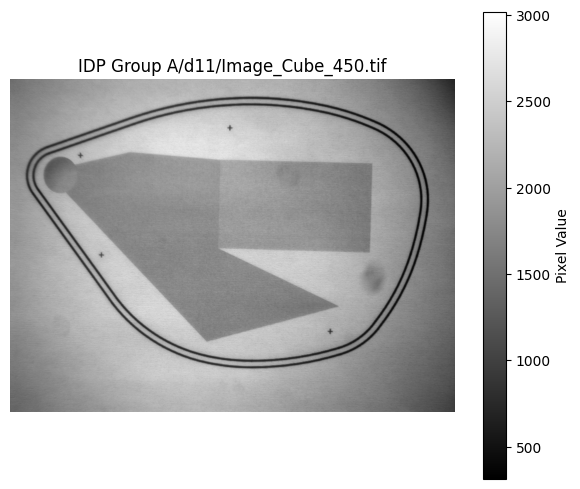

In [2]:
def plot_image(image, title=""):
    # Plot the image
    plt.figure(figsize=(6, 5))
    plt.imshow(image, cmap="gray")
    plt.colorbar(label="Pixel Value")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_example_reflectance(reflectance_cubes, sample_name, wavelength):
    # Get reflectance cube
    R = reflectance_cubes[sample_name]

    # Extract 2D image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]
    title = f"Reflectance of {sample_name} at {wavelength} nm"

    plot_image(reflectance_image, title)


def plot_original_tif(tif_path):
    image = tiff.imread(tif_path)

    plot_image(image, tif_path)


plot_example_reflectance(reflectance_cubes, "d11", 450)
plot_original_tif("IDP Group A/d11/Image_Cube_450.tif")

In [ ]:
def detect_crosses(img, template, threshold=0.6, max_overlap=10):
    # Ensure both are float32
    img = img.astype(np.float32)
    template = template.astype(np.float32)
    th, tw = template.shape

    # Perform normalized cross-correlation
    result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

    # Find locations exceeding threshold
    ys, xs = np.where(result >= threshold)
    scores = result[ys, xs]

    detections = sorted(zip(xs, ys, scores), key=lambda x: -x[2])
    filtered = []

    for x, y, s in detections:
        if all(np.hypot(x - fx, y - fy) > max_overlap for fx, fy, _ in filtered):
            filtered.append((x, y, s))

    # Return centers
    centers = [(y + th // 2, x + tw // 2) for x, y, _ in filtered]
    return centers, result

template = reference[7,235:255,245:265]
ref_img = reference[7]
crosses, corr_map = detect_crosses(ref_img, template, threshold=0.65)

In [ ]:
import numpy as np
import cv2

def detect_cross_centroids(img_norm):
    thresh = (img_norm > 0.8).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    
    return centroids
def average_x(centroids):
    return np.mean([pt[0] for pt in centroids])
def align_image(img_norm, shift_x):
    rows, cols = img_norm.shape
    M = np.float32([[1, 0, shift_x], [0, 1, 0]])
    aligned = cv2.warpAffine(img_norm, M, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return aligned

In [ ]:
ref_img = reference[wavelengths.index(450)]
ref_centroids = detect_cross_centroids(ref_img)
ref_avg_x = average_x(ref_centroids)

spectral_cube = reflectance_cubes['d1']
img = spectral_cube[wavelengths.index(450)]
centroids = detect_cross_centroids(img)
avg_x = average_x(centroids)
shift = ref_avg_x - avg_x
aligned_img = align_image(img, shift)


Cross centers: []
Cross centers: []


C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


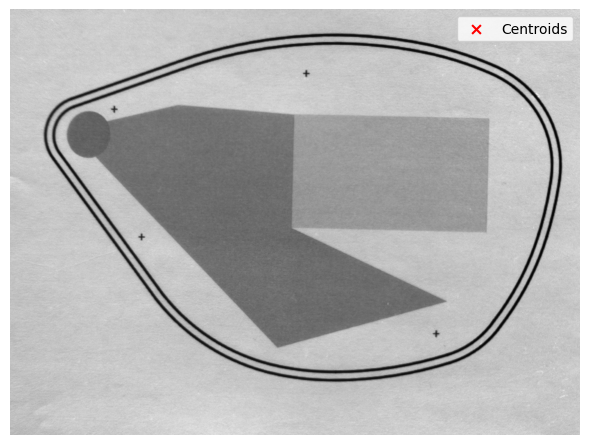

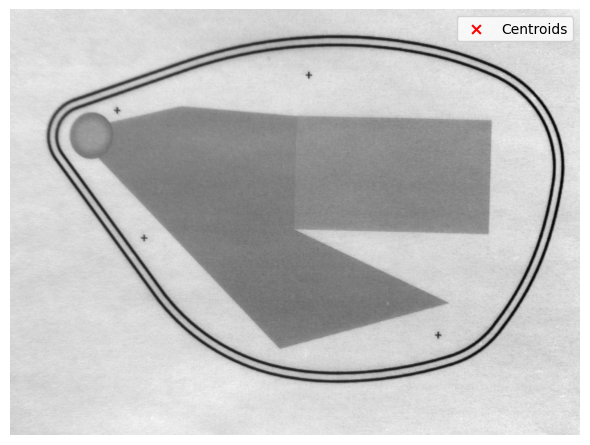

In [130]:
def plot_image_with_centroids(img_norm, centroids):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_norm, cmap='gray', origin='upper')
    
    # Unpack centroid coordinates
    xs, ys = zip(*centroids) if centroids else ([], [])
    
    # Overlay centroids
    plt.scatter(xs, ys, c='red', s=40, marker='x', label='Centroids')
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_image_with_centroids(ref_img, ref_centroids)
plot_image_with_centroids(img, centroids)

In [131]:
from sklearn.decomposition import PCA
from scipy.ndimage import binary_fill_holes
class lense_image():
    def __init__(self, spectral_cube, wavelengths):
        self.reflectances = spectral_cube
        self.RGB = spectral_cube[[wavelengths.index(650), wavelengths.index(550), wavelengths.index(470)], :, :]
        self.IC_mask = None
        self.IC_center = None
        self.IC_mean = None
        self.IC_std = None
        self.circularity = None
        self.n_pixels = None


    def align_images_affine(self, img_ref, feature_detector='ORB', max_features=5000, good_match_percent=0.15):

        img_to_align = self.reflectances[wavelengths.index(450)]
        img_ref_8u = (img_ref * 255).astype(np.uint8)
        img_align_8u = (img_to_align * 255).astype(np.uint8)

        # Feature detector
        if feature_detector.upper() == 'SIFT':
            detector = cv2.SIFT_create(max_features)
        elif feature_detector.upper() == 'BRISK':
            detector = cv2.BRISK_create()
        else:
            detector = cv2.ORB_create(max_features)

        # Detect and compute features
        kp1, des1 = detector.detectAndCompute(img_ref_8u, None)
        kp2, des2 = detector.detectAndCompute(img_align_8u, None)

        # Matcher
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING if feature_detector.upper() == 'ORB' else cv2.NORM_L2)
        matches = matcher.match(des1, des2, None)

        # Sort matches by descriptor distance
        matches = sorted(matches, key=lambda x: x.distance)
        num_good_matches = int(len(matches) * good_match_percent)
        matches = matches[:num_good_matches]

        # Draw matches for visualization
        matches_img = cv2.drawMatches(
            img_ref_8u, kp1, img_align_8u, kp2, matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Display with matplotlib
        plt.figure(figsize=(12, 6))
        plt.imshow(matches_img[..., ::-1])  # Convert BGR → RGB for plotting
        plt.title(f"ORB Matches ({len(matches)} good out of {len(matches)} total)")
        plt.axis("off")
        plt.show()
        # Extract matched points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        # Estimate affine transformation using RANSAC
        M, inliers = cv2.estimateAffinePartial2D(pts2, pts1, method=cv2.RANSAC)

        # Apply affine warp
        height, width = img_ref.shape
        aligned = cv2.warpAffine(img_to_align, M, (width, height))

        return aligned, M
        


    def compute_IC_mask_PCA(self):
        spectra = self.reflectances.copy()
        bands, height, width = spectra.shape
        pixels = spectra.reshape(bands,-1).T
        pixels /= np.linalg.norm(pixels, axis=1, keepdims=True) + 1e-6

        # Apply k means clustering
        pca = PCA(n_components=3, random_state=0)
        pixels_pca = pca.fit_transform(pixels)
        k_means = KMeans(n_clusters=5, random_state=0, n_init=10)
        labels = k_means.fit_predict(pixels_pca)

        # Reshape labels to image shape
        segmented_image = labels.reshape(height, width)
        self.segmented_im = segmented_image
       
        # Extract mask for IC region
        pixel_IC = (300,190) # TODO algorithm instead of manually
        IC_label = segmented_image[pixel_IC]
        mask = (segmented_image == IC_label).astype(int)

        # Flood filly from circle to keep only connected region
        flood_mask = mask.copy()
        cv2.floodFill(flood_mask, None, (pixel_IC[1], pixel_IC[0]), 128)  # TODO

        # Extract filled region
        circle_mask = np.uint8(flood_mask == 128)
        self.IC_mask = circle_mask
        self.n_pixels = np.count_nonzero(circle_mask == 1)

        plt.imshow(circle_mask, cmap='gray')
        plt.axis('off')
        plt.title('IC region')
        plt.show()


    def compute_IC_mask(self):
        spectra = self.RGB.copy()
        bands, height, width = spectra.shape
        pixels = spectra.reshape(bands,-1).T
        pixels /= np.linalg.norm(pixels, axis=1, keepdims=True) + 1e-6

        # Apply k means clustering
        k_means = KMeans(n_clusters=5, random_state=0, n_init=10)
        labels = k_means.fit_predict(pixels)

        # Reshape labels to image shape
        segmented_image = labels.reshape(height, width)
        self.segmented_im = segmented_image
       
        # Extract mask for IC region
        pixel_IC = (300,190) # TODO algorithm instead of manually
        IC_label = segmented_image[pixel_IC]
        mask = (segmented_image == IC_label).astype(int)

        # Flood filly from circle to keep only connected region
        flood_mask = mask.copy()
        cv2.floodFill(flood_mask, None, (pixel_IC[1], pixel_IC[0]), 128)  # TODO

        # Extract filled region
        circle_mask = np.uint8(flood_mask == 128)


        # Morphological closing to close small gaps and fill any internal holes
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        closed = cv2.morphologyEx(circle_mask, cv2.MORPH_CLOSE, kernel)
        filled = binary_fill_holes(closed > 0)

        self.IC_mask = filled#[None, :, :]  # shape: (1, H, W)
        self.n_pixels = np.count_nonzero(circle_mask == 1)

        print(f"Number of pixels in the circle: {self.n_pixels}")

        plt.imshow(filled, cmap='gray')
        plt.axis('off')
        plt.title('IC region')
        plt.show()

        
    def CTQs(self, ref_mask):
        #self.compute_IC_mask()
        #masked_pixels = self.RGB * ref_mask
        #plt.imshow(np.transpose(masked_pixels, (1, 2, 0)))
        
        masked_pixels = self.RGB[:, ref_mask != 0]  # shape -> (3, N)

        mean_val = np.array([
            masked_pixels[c].mean() 
            for c in range(masked_pixels.shape[0])
        ])
        std_val = np.array([
            masked_pixels[c].std() 
            for c in range(masked_pixels.shape[0])
        ])

        print("Mean for each channel:", mean_val)
        self.IC_mean = mean_val
        self.IC_std = std_val
    

Number of pixels in the circle: 9520


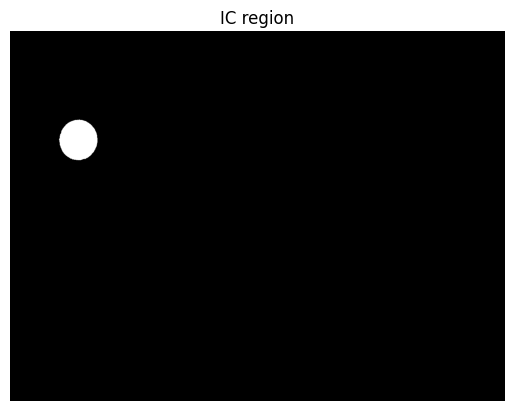

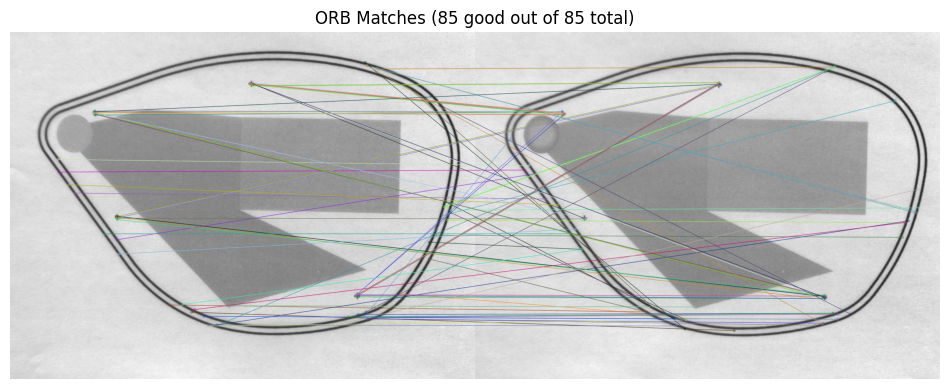

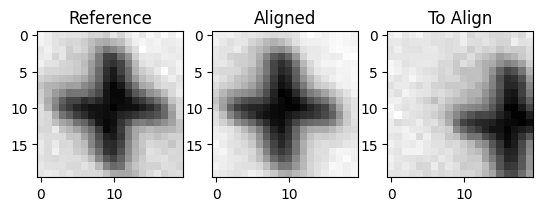

Mean for each channel: [0.43712149 0.48565255 0.71636975]


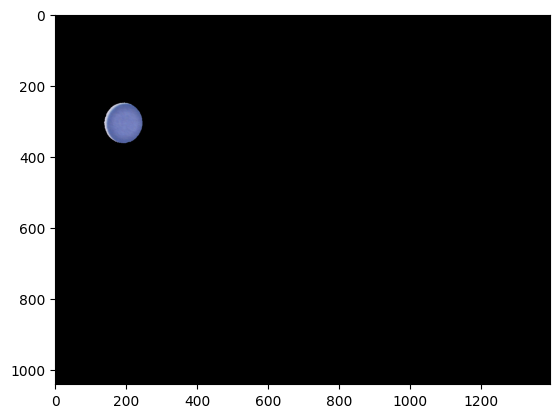

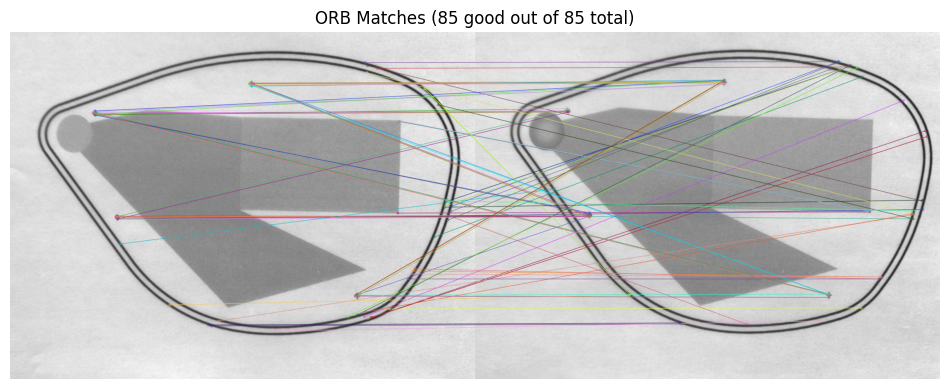

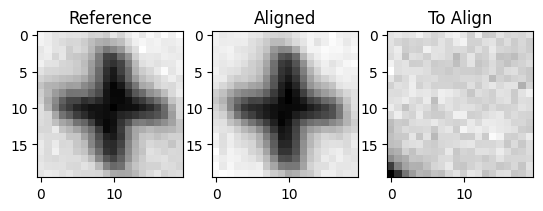

Mean for each channel: [0.49909264 0.53013388 0.71550394]


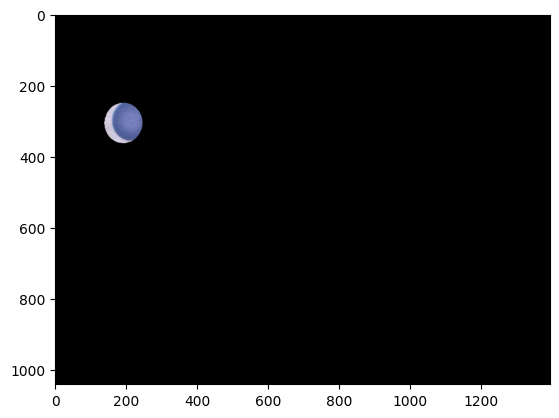

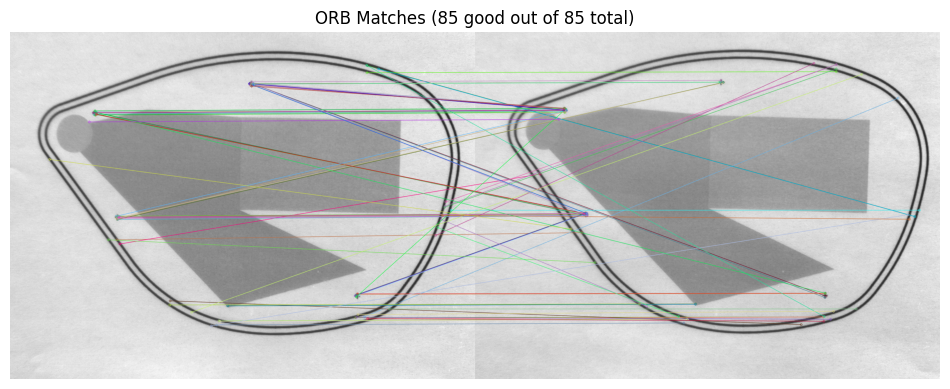

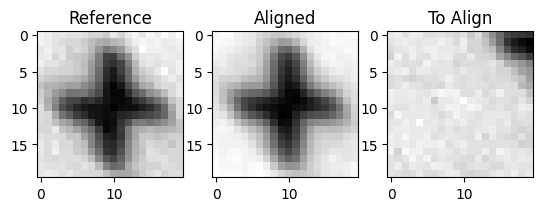

Mean for each channel: [0.53309728 0.60902159 0.69262971]


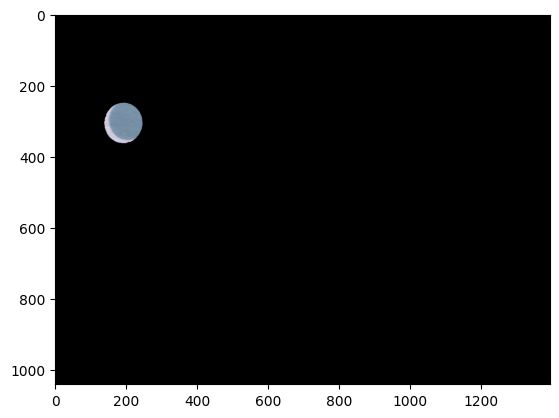

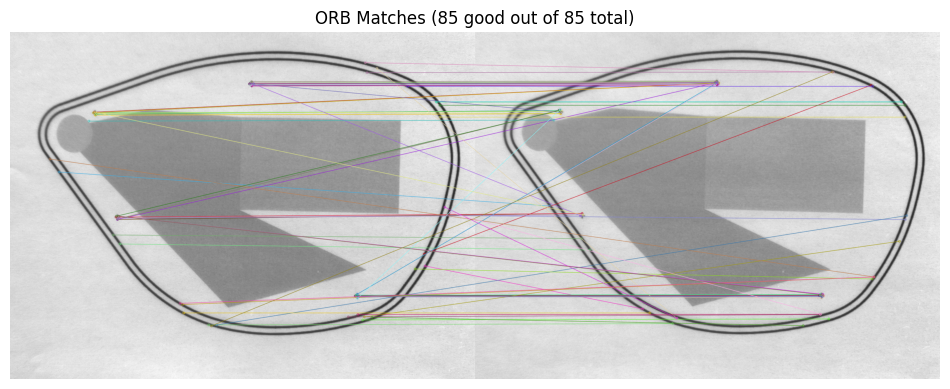

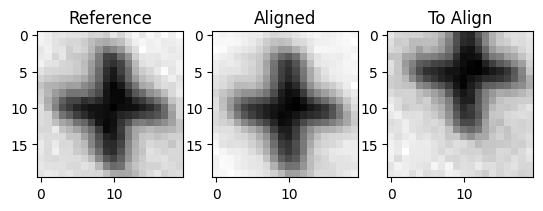

Mean for each channel: [0.47950221 0.49333117 0.7468747 ]


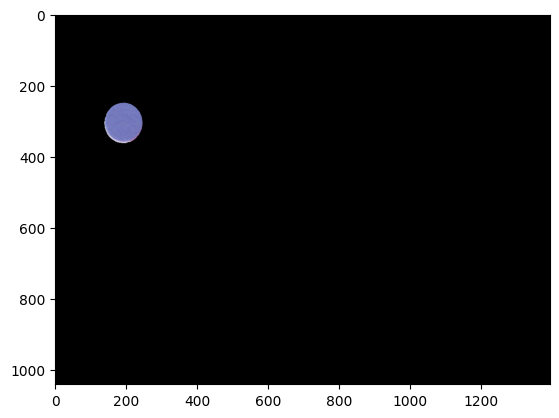

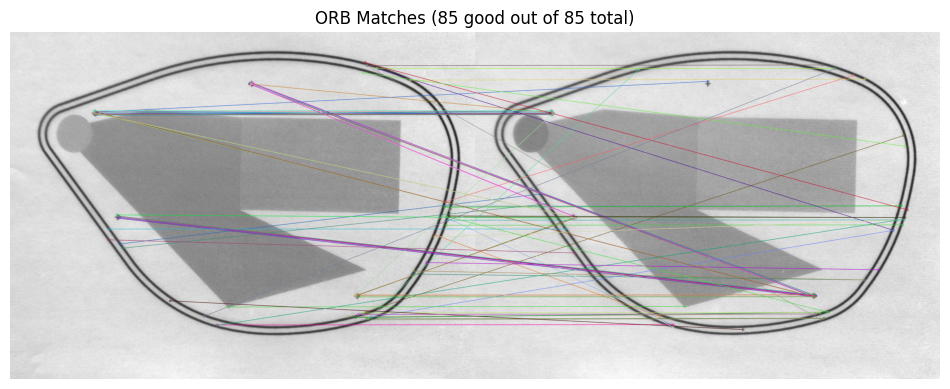

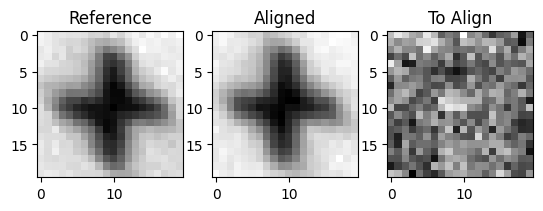

Mean for each channel: [0.44555515 0.43173446 0.64330808]


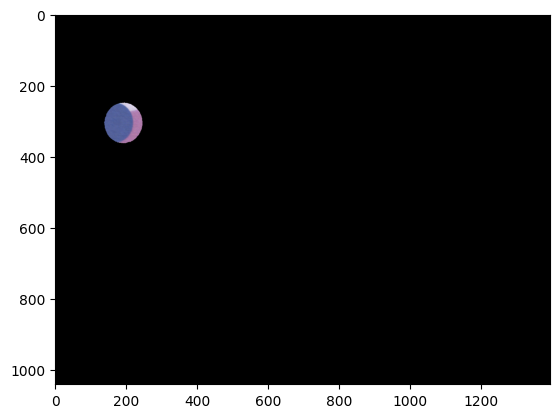

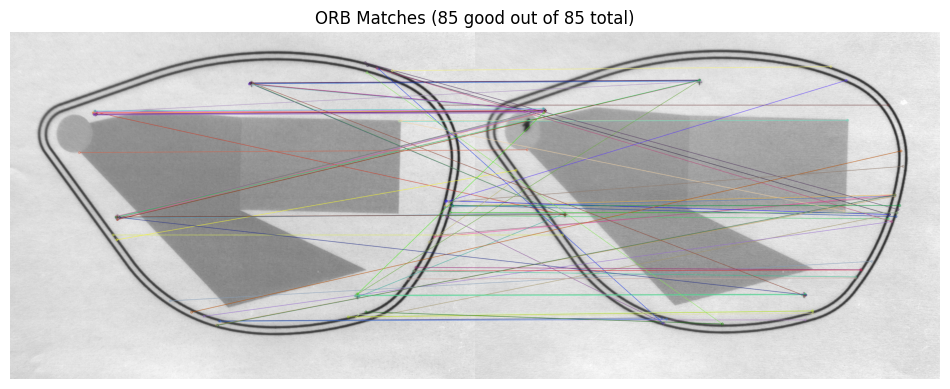

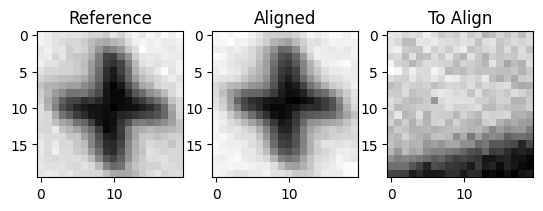

Mean for each channel: [0.59566375 0.49317837 0.69219431]


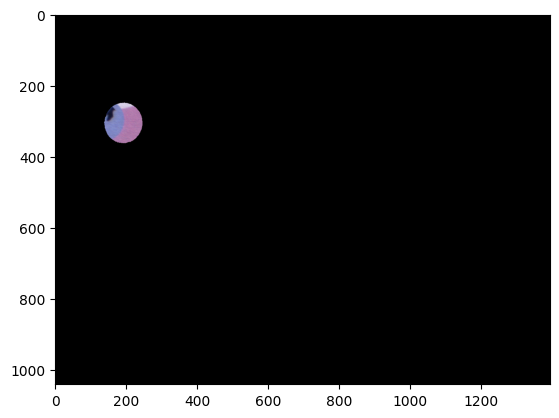

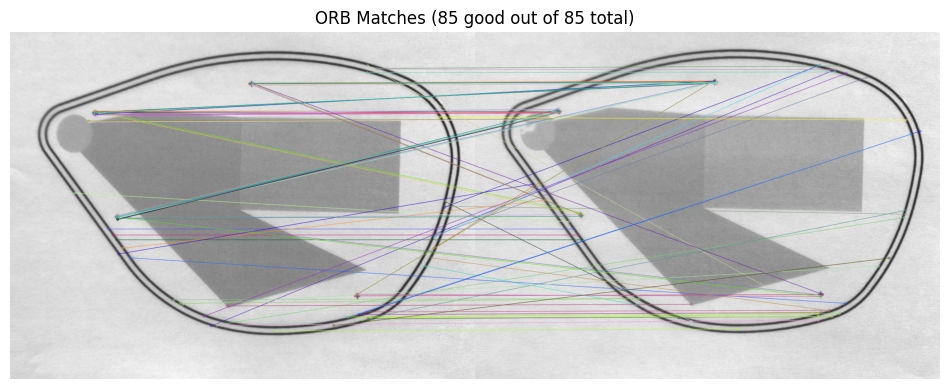

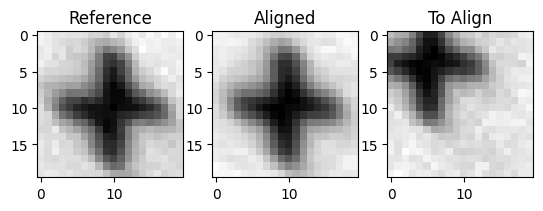

Mean for each channel: [0.54942    0.55683332 0.78016087]


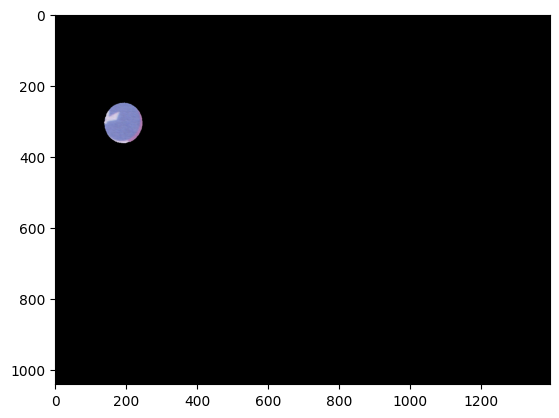

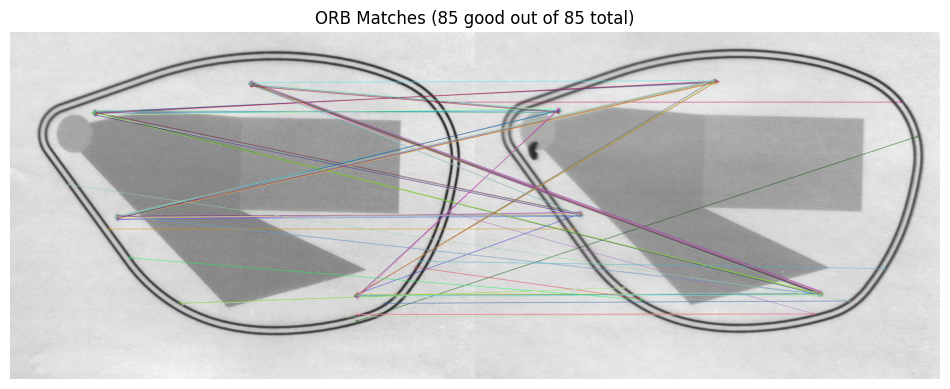

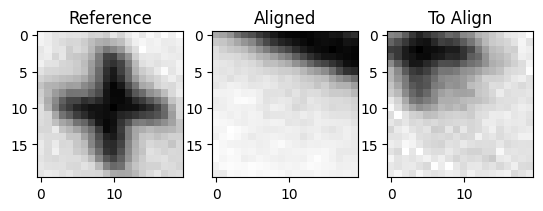

Mean for each channel: [0.49091931 0.51032132 0.73193607]


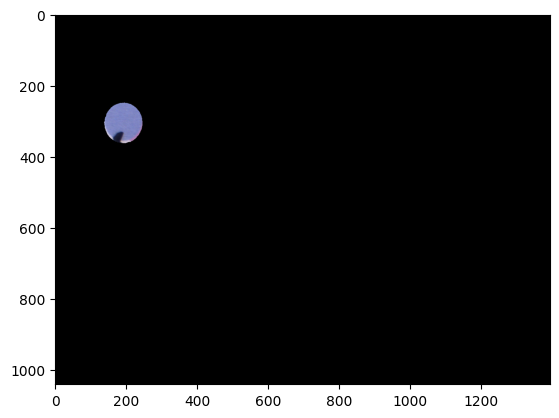

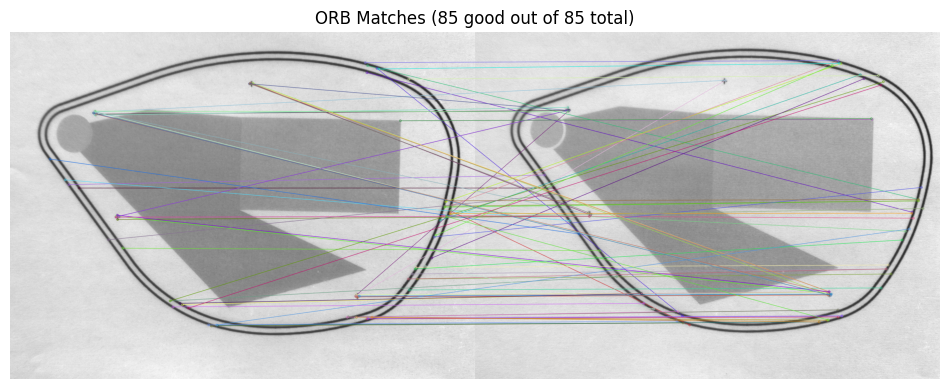

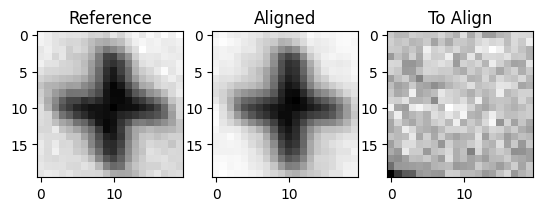

Mean for each channel: [0.61268845 0.62301969 0.81272593]


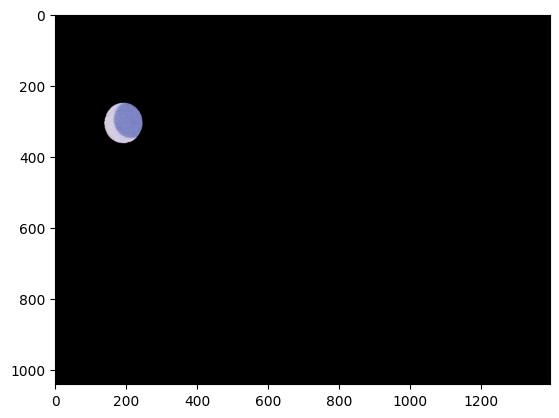

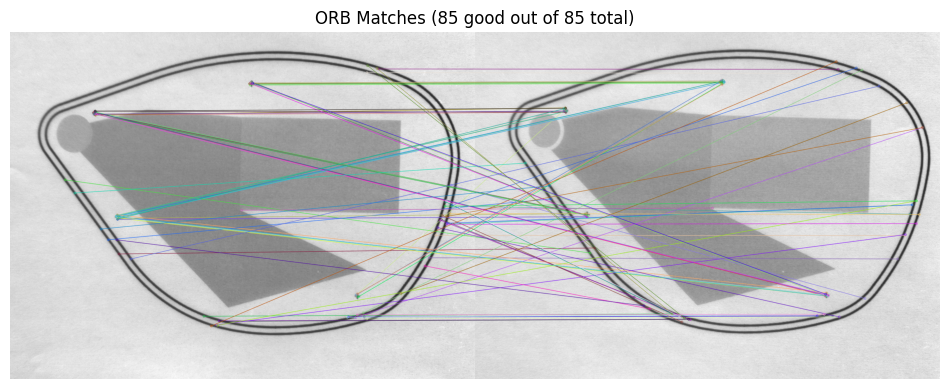

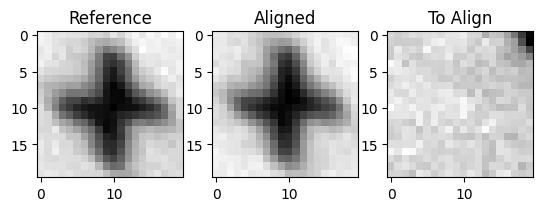

Mean for each channel: [0.60823312 0.61968771 0.81473675]


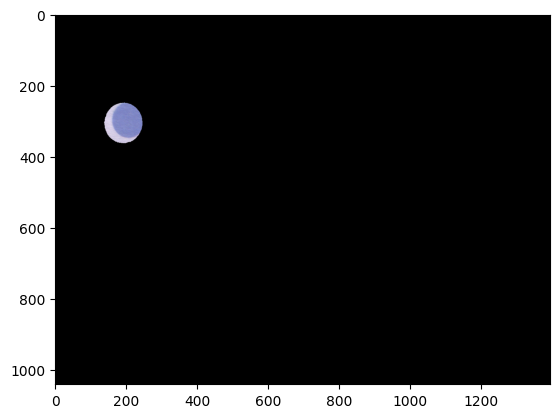

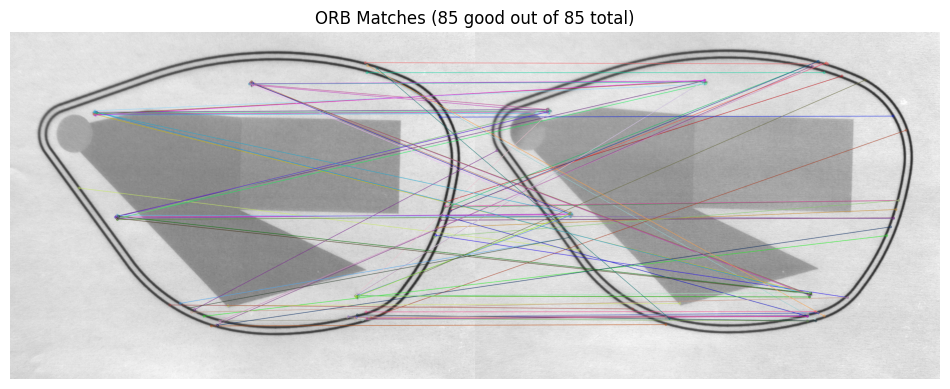

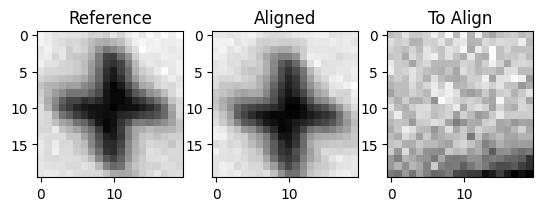

Mean for each channel: [0.56424814 0.50891339 0.72391759]


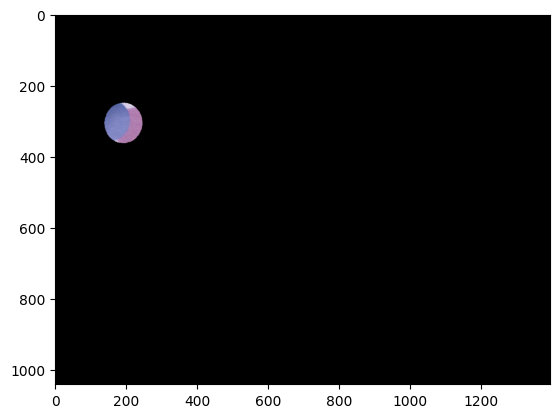

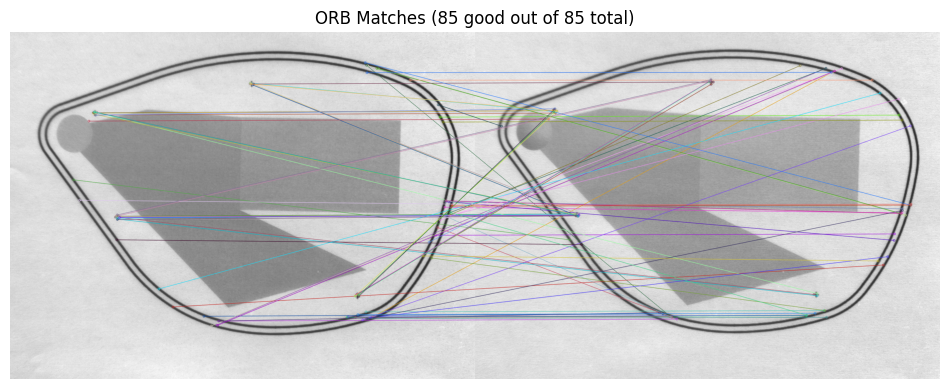

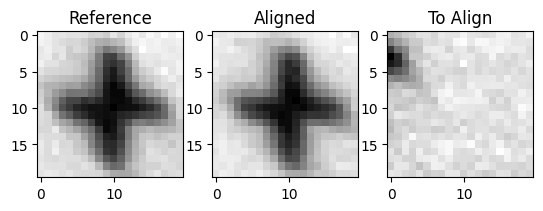

Mean for each channel: [0.48511241 0.47992973 0.70736945]


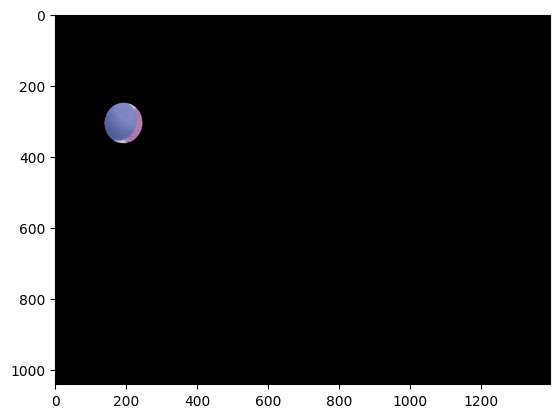

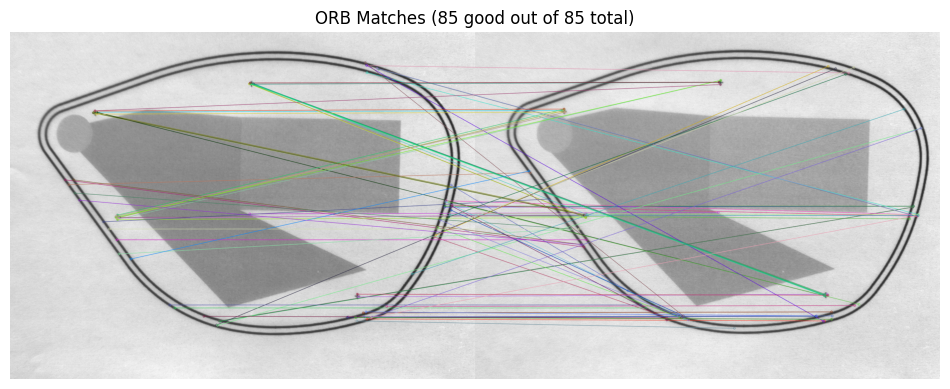

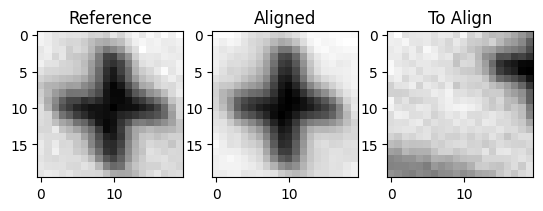

Mean for each channel: [0.67901811 0.67928099 0.8465643 ]


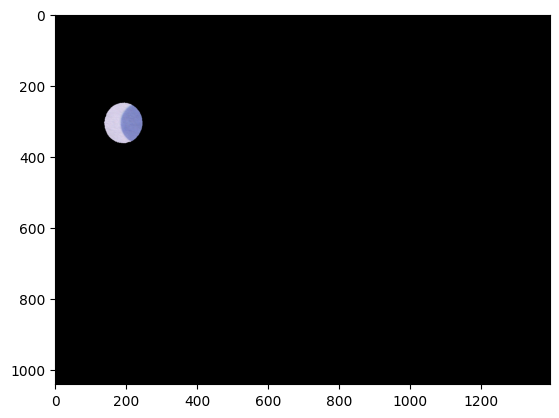

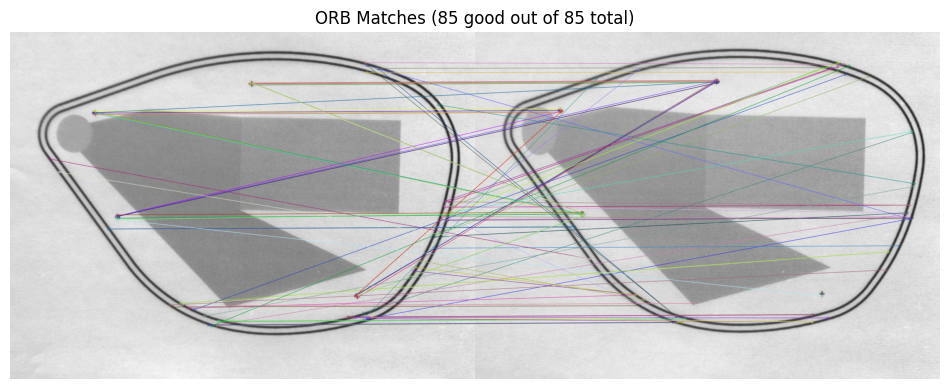

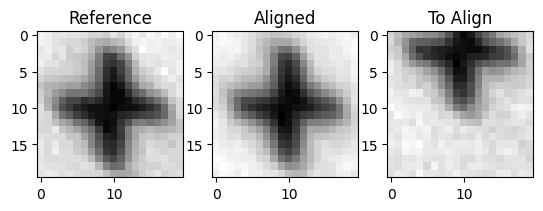

Mean for each channel: [0.50390234 0.52878976 0.76415692]


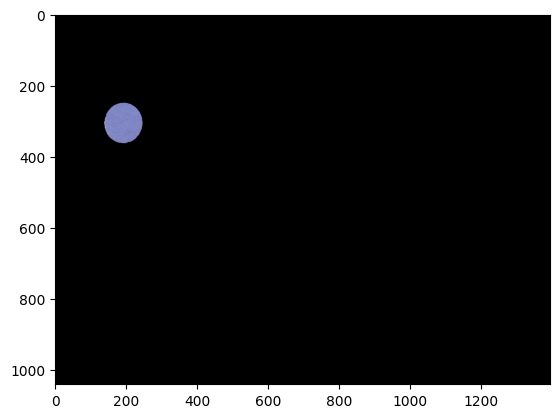

In [132]:
# 2. Compute CTQs for reference
reference_lense = lense_image(reference, wavelengths)
reference_lense.compute_IC_mask()
#reference_lense.CTQs()

# 3. Compute CTQs for each defect
img_ref = reference[wavelengths.index(450)]
for folder in sample_folders:
    lense = lense_image(reflectance_cubes[folder], wavelengths)
    aligned, H = lense.align_images_affine(img_ref, feature_detector='ORB')
    # Visualization
    plt.subplot(1, 3, 1)
    plt.title("Reference")
    plt.imshow(img_ref[235:255,245:265], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Aligned")
    plt.imshow(aligned[235:255,245:265], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("To Align")
    plt.imshow(lense.reflectances[wavelengths.index(450),235:255,245:265], cmap="gray")
    plt.show()

    lense.CTQs(reference_lense.IC_mask)
    aaa = lense.RGB * reference_lense.IC_mask[None, :, :]
    aaa = np.transpose(aaa, (1, 2, 0))
    plt.imshow(aaa)
    plt.show()

   
# 4. Compare each lense to reference

In [ ]:
# 2. Compute CTQs for reference
reference_lense = lense_image(reference, wavelengths)
reference_lense.CTQs()

# 3. Compute CTQs for each defect
defects_means = []
defects_stds = []
for folder in sample_folders:
    lense = lense_image(reflectance_cubes[folder], wavelengths)
    lense.CTQs()
    defects_means.append(lense.IC_mean)
    defects_stds.append(lense.IC_std)
   
# 4. Compare each lense to reference

In [37]:
r = reference_lense.IC_mean[0]
g = reference_lense.IC_mean[1]
b  = reference_lense.IC_mean[2]

for m, d in zip(defects_means, defects_stds):
    print(((m[0]-r)**2+(m[1]-g)**2+(m[2]-b)**2)**(1/2), d.mean())

0.08241543254381868 0.04770717387387208
0.14522329075617885 0.05378813398813473
0.11367105216770186 0.028707422341715177
0.020172929979810263 0.026718066972016983
0.20563187188760743 0.03377352267098634
0.02714822366246535 0.10396714481082203
0.07550091719030433 0.03369623330452043
0.038535913186942154 0.13752126167043227
0.05982416989687416 0.025005965907959556
0.07425297297356807 0.025066254739944043
0.05488145822373116 0.0643836611528663
0.06369159018032602 0.06556986520084596
0.06862165126560975 0.025123343349293698
0.05971666400445492 0.023096471742188044


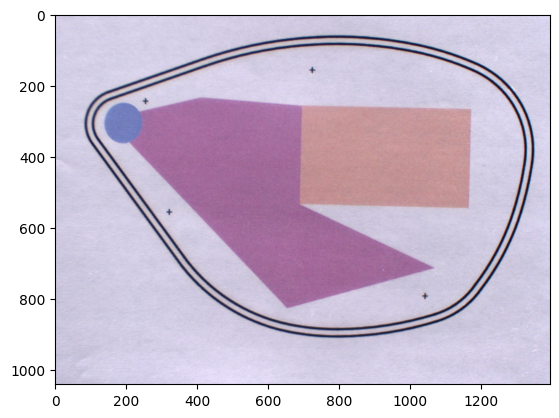

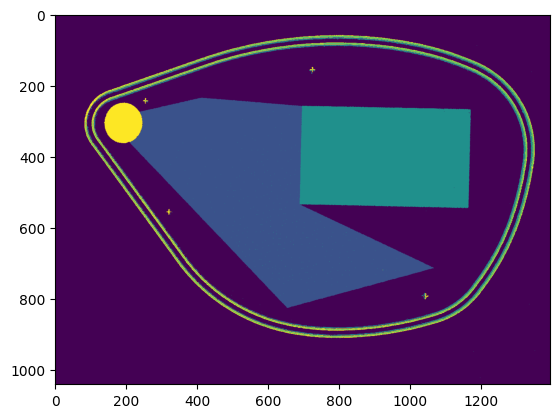

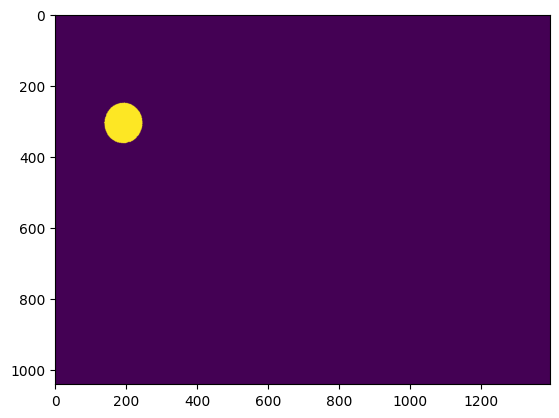

In [115]:
img = reference_lense.RGB
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.show()
plt.imshow(reference_lense.segmented_im)
plt.show()
plt.imshow(reference_lense.IC_mask[0])
plt.show()

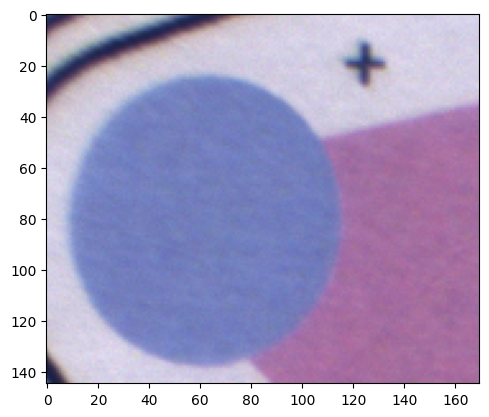

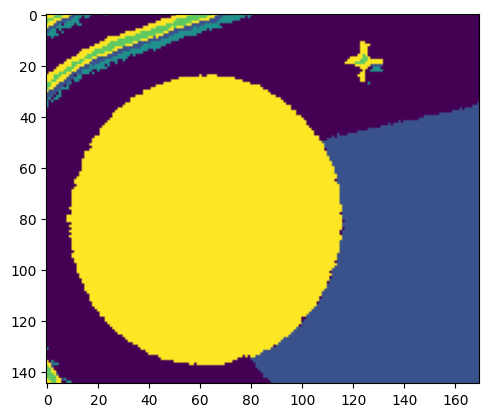

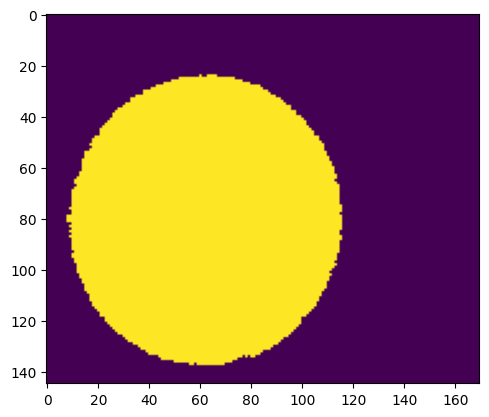

In [102]:
img = reference_lense.RGB
img = np.transpose(img, (1, 2, 0))
plt.imshow(img[225:370,130:300])
plt.show()
plt.imshow(reference_lense.segmented_im[225:370,130:300])
plt.show()
plt.imshow(reference_lense.IC_mask[0,225:370,130:300])
plt.show()

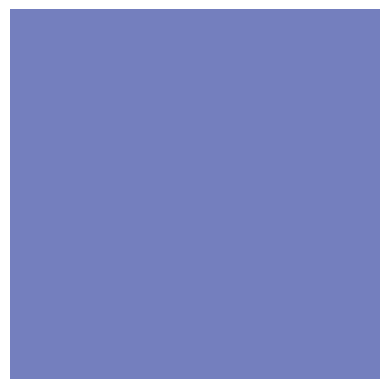

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# RGB color (normalized between 0–1)
color = np.array([0.4569986, 0.50187844, 0.74701582])

# Create a 1×1 image of that color
patch = np.ones((10, 10, 3)) * color

plt.imshow(patch)
plt.axis("off")
plt.show()
